<a href="https://colab.research.google.com/github/shivammehta007/Social-Network-Analysis/blob/master/Demographic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictiing Demographic Information

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import scipy.sparse as sp
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline
# Setting up custom random seeds,
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)


## Opening Data

In [0]:
data_path = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'SNA Lab', 'SNA-Lab3')
file_london = pd.read_csv(os.path.join(data_path, 'LondonTrain.csv'))
file_newyork = pd.read_csv(os.path.join(data_path, 'NYTrain.csv'))
file_singapore = pd.read_csv(os.path.join(data_path, 'SingaporeTrain.csv'))

## EDA: Exploratory Data Analysis

### Heads

In [0]:
# Dropping Row ID
file_london.drop(['row ID'], axis=1, inplace=True)
file_newyork.drop(['row ID'], axis=1, inplace=True)
file_singapore.drop(['row ID'], axis=1, inplace=True)

In [7]:
file_london.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Edenred Employee Benefits Advisor November 20...,female,NaN,NaN,NaN,NaN,personal care and service,NaN
2,"Uppsala University Egyptology Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN
4,University of Verona 2008 to 2010 Nursing Ve...,Coogee Pavilion Pizza Chef 13 April 2015 to p...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN


In [8]:
file_newyork.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,Universidad Santo Toms Class of 2009 Psycholo...,GMO Chile Analista de Seleccin y Desarrollo A...,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,male,NaN,NaN,in a relationship,NaN,NaN,NaN
3,NaN,Commonwealth of Massachusetts Legislative Aide...,male,NaN,NaN,NaN,NaN,healthcare support,NaN
4,NaN,Mindshare Pan Regional Director 1 October 201...,female,NaN,NaN,NaN,NaN,management,NaN


In [9]:
file_singapore.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,Bukit Batok Secondary School ITE College West ...,NaN,female,NaN,NaN,NaN,college,NaN,NaN
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN
3,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,$$
4,NaN,PT. Duta Marga Lestarindo September 2013 to pr...,female,NaN,NaN,NaN,NaN,archetecture and engineering,NaN


In [10]:
file_singapore.isnull().sum(axis=0) 

educationInfoForAgeGroupEstimation    2498
workInfoForAgeGroupEstimation         3063
gender                                  11
realAge                               4500
ageGroup                              3640
relationship                          3584
educationLevel                        3073
occupation                            3856
income                                4320
dtype: int64

In [11]:
column_names = file_singapore.columns
for i in column_names:
    print('{} Value Length : {}'.format(i, len(file_newyork[i].unique())))

educationInfoForAgeGroupEstimation Value Length : 674
workInfoForAgeGroupEstimation Value Length : 947
gender Value Length : 3
realAge Value Length : 1
ageGroup Value Length : 1
relationship Value Length : 4
educationLevel Value Length : 5
occupation Value Length : 22
income Value Length : 5


In [0]:
# Add city column in each and merge them
file_london['city'] = 'London'
file_newyork['city'] = 'New York'
file_singapore['city'] = 'Singapore'

train_data = pd.concat([file_london, file_newyork, file_singapore])

In [13]:
train_data.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income,city
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN,London
1,NaN,Edenred Employee Benefits Advisor November 20...,female,NaN,NaN,NaN,NaN,personal care and service,NaN,London
2,"Uppsala University Egyptology Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN,London
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN,London
4,University of Verona 2008 to 2010 Nursing Ve...,Coogee Pavilion Pizza Chef 13 April 2015 to p...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN,London


### EDA

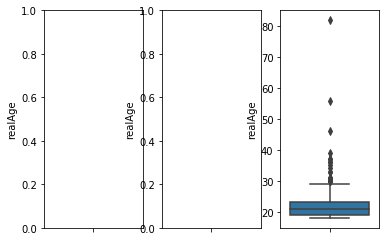

In [14]:
# Age Analysis
fig, axis = plt.subplots(1, 3)
sns.boxplot(y=file_london['realAge'], ax=axis[0])
sns.boxplot(y=file_newyork['realAge'], ax=axis[1])
sns.boxplot(y=file_singapore['realAge'], ax=axis[2])
plt.show()

In [15]:
print(file_london['ageGroup'].unique(), file_newyork['ageGroup'].unique(), file_singapore['ageGroup'].unique())

[nan] [nan] [nan 'AGE10_20' 'AGE20_30' 'AGE30_40' 'AGE40_50' 'AGE50_INF']


educationInfoForAgeGroupEstimation    1150
workInfoForAgeGroupEstimation         1402
gender                                3248
realAge                                  0
ageGroup                                 0
relationship                           459
educationLevel                         874
occupation                             966
income                                 149
city                                  3278
dtype: int64

### Plotting Number of Samples

In [0]:
def plot_class(dataset):
    columns = dataset.columns
    column_count = list(dataset.count())
    names = dataset.count().keys()
    plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel('Labels')
    plt.ylabel('Number of Samples')
    index = np.arange(len(columns))
    plt.xticks(index, names, fontsize=8, rotation=70)
    plt.bar(columns, column_count)
    plt.show()

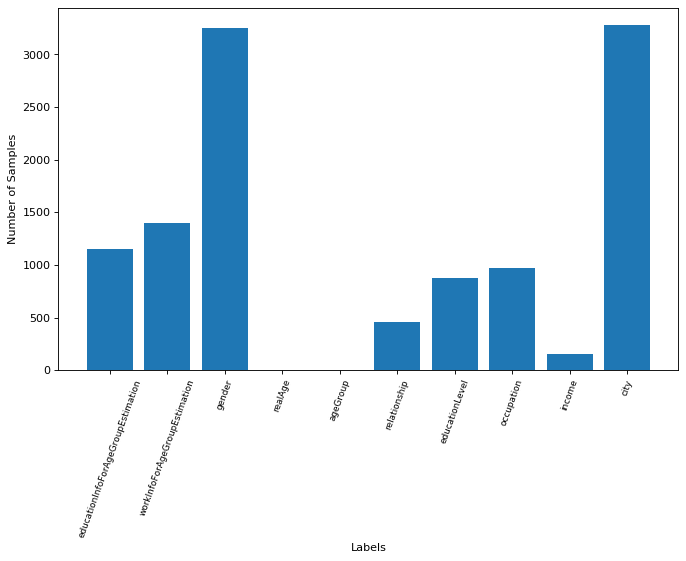

In [127]:
plot_class(file_london)

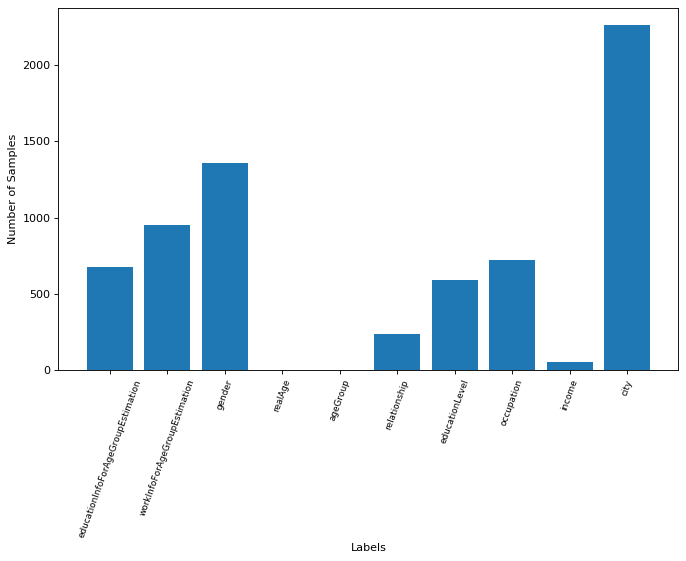

In [128]:
plot_class(file_newyork)

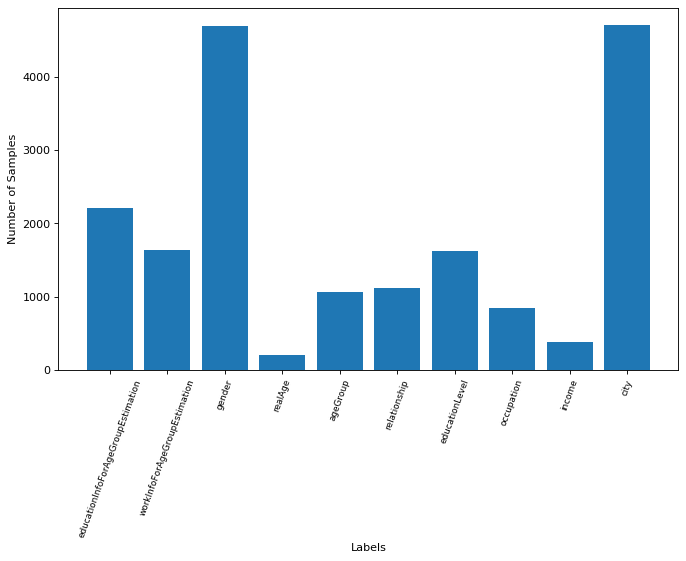

In [129]:
plot_class(file_singapore)

## Data Pre Processing

In [0]:
class PreProcessor:
    """
    Takes a raw DataFrame as input and returns a cleaned and processor
    """
    def __init__(self, nan_drop_threshold=5, train=True, gender_dict=gender_dict, age_group_dict=age_group_dict,
                 city_dict=city_dict):
        self.nan_drop_threshold = nan_drop_threshold
        self.train = train
        self.unknown_token = 'UNKNOWN'

        # Label Encoder for Labels
        self.gender_encoder = LabelEncoder()
        self.age_group_encoder = LabelEncoder()
        self.relationship_encoder = LabelEncoder()
        self.education_encoder = LabelEncoder()
        self.occupation_encoder = LabelEncoder()
        self.income_encoder = LabelEncoder()
        self.city_encoder = LabelEncoder()

        # Count Vectorizer for Input Fields
        self.cv = CountVectorizer()

    def _clean_train(self, dataframe):

        dataframe.dropna(thresh=5, axis=0, inplace=True)

        # Unknown Tokens
        dataframe.fillna(self.unknown_token, inplace=True)

        # -------------------- Labels --------------------

        # Quantize Gender
        dataframe['gender'] = self.gender_encoder.fit_transform(dataframe['gender'])
        
        # Quantize known and UNKNOWN age groups
        dataframe['ageGroup']= self.age_group_encoder.fit_transform(dataframe['ageGroup'])

        # Qunatize Relationship
        dataframe['relationship'] = self.relationship_encoder.fit_transform(dataframe['relationship'])

        # Quantize Education level
        dataframe['educationLevel'] = self.education_encoder.fit_transform(dataframe['educationLevel'])

        # Quantize Occupation Level
        dataframe['occupation'] = self.occupation_encoder.fit_transform(dataframe['occupation'])

        # Quantize Income
        dataframe['income'] = self.income_encoder.fit_transform(dataframe['income'])

        # Quantize City
        dataframe['city'] = self.city_encoder.fit_transform(dataframe['city'])

        # ------------------- Training Fields ---------------

        # Update educationInfoForAgeGroupEstimation to CountVectorizing
        dataframe['educationInfoForAgeGroupEstimation'] = dataframe['educationInfoForAgeGroupEstimation'].str.lower()

        # Update workInfoForAgeGroupEstimation to Count Vectorizing 
        dataframe['workInfoForAgeGroupEstimation'] = dataframe['workInfoForAgeGroupEstimation'].str.lower()

        X_train = sp.hstack(dataframe[['educationInfoForAgeGroupEstimation', 'workInfoForAgeGroupEstimation']]
                            .apply(lambda col: self.cv.fit_transform(col)))
        
        # Drop Real Age
        dataframe.drop(['realAge'], axis=1, inplace=True)

        return X_train, dataframe


    def _clean_test(self, dataframe):

        # Unknown Tokens
        dataframe.fillna(self.unknown_token, inplace=True)

        # -------------------- Labels --------------------

        # Quantize Gender
        dataframe['gender'] = self.gender_encoder.transform(dataframe['gender'])
        
        # Quantize known and UNKNOWN age groups
        dataframe['ageGroup']= self.age_group_encoder.transform(dataframe['ageGroup'])

        # Qunatize Relationship
        dataframe['relationship'] = self.relationship_encoder.transform(dataframe['relationship'])

        # Quantize Education level
        dataframe['educationLevel'] = self.education_encoder.transform(dataframe['educationLevel'])

        # Quantize Occupation Level
        dataframe['occupation'] = self.occupation_encoder.transform(dataframe['occupation'])

        # Quantize Income
        dataframe['income'] = self.income_encoder.transform(dataframe['income'])

        # Quantize City
        dataframe['city'] = self.city_encoder.transform(dataframe['city'])

        # ------------------- Training Fields ---------------

        # Update educationInfoForAgeGroupEstimation to CountVectorizing
        # dataframe['educationInfoForAgeGroupEstimation'] = self.cv.transform(dataframe['educationInfoForAgeGroupEstimation'])

        # Update workInfoForAgeGroupEstimation to Count Vectorizing 
        # dataframe['workInfoForAgeGroupEstimation'] = self.cv.transform(dataframe['workInfoForAgeGroupEstimation'])

        X_test = sp.hstack(dataframe[['educationInfoForAgeGroupEstimation', 'workInfoForAgeGroupEstimation']].apply(lambda col: self.cv.transform(col)))

        
        # Drop Real Age
        dataframe.drop(['realAge'], axis=1, inplace=True)

        return X_test, dataframe

    def fit(self, dataframe):
        """
        The Clean method will clean the dataframe 
        Operations Performed:
        * Remove the Rows with more than 5 nan's if Train set
        * Mark NAN's with Unknown Tokens
        * Replace Gender to numeric values
        * Replace Age Group to numeric values
        * Replace Relationship to numeric values
        * Replace Education Level to numeric values
        * Replace Occupation Level to numeric values
        * Replace Income to numeric values
        * Replace City to numeric values
        * Count Vectorize Education Info
        * Count Vectorize Work Info

        Parameters:
        dataframe: Pandas DataFrame

        Output:
        dataframe: Pandas DataFrame
        """

        if self.train:
            X, dataframe = self._clean_train(dataframe)
        else:
            X, dataframe = self._clean_test(dataframe)


        return X, dataframe


        


In [0]:
pre_processor_train = PreProcessor()

In [0]:
X_data, Y_data = pre_processor_train.fit(train_data)

In [0]:
Y_data = Y_data.loc[:, ['gender', 'ageGroup', 'relationship',  'city']]

## Classic ML Classifiers

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=SEED)

In [26]:
X_train.shape, y_train.shape

((2434, 19109), (2434, 4))

### Support Vector Machines

In [79]:
f1_scores_svm = []

for column in y_train.columns:
    current_column = y_train[column]

    svm = SVC(kernel='rbf')
    svm.fit(X_train, current_column)

    prediction = svm.predict(X_test)

    f1 = f1_score(prediction, y_test[column], average='weighted')
    f1_scores_svm.append((column, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true sample

In [87]:
print('-------------- SVM: F1 Scores --------------')
for f in f1_scores_svm:
    print('{:20} : {:.4f}'.format(str.capitalize(f[0]), f[1]))

-------------- SVM: F1 Scores --------------
Gender               : 0.7672
Agegroup             : 0.7953
Relationship         : 0.7339
City                 : 0.7075


### Random Forest

In [81]:
f1_scores_rfc = []

for column in y_train.columns:
    current_column = y_train[column]


    rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)
    rfc.fit(X_train, current_column)

    prediction = rfc.predict(X_test)

    f1 = f1_score(prediction, y_test[column], average='weighted')
    f1_scores_rfc.append((column, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [89]:
print('-------------- Random Forest: F1 Scores --------------')
for f in f1_scores_rfc:
    print('{:20} : {:.4f}'.format(str.capitalize(f[0]), f[1]))

-------------- Random Forest: F1 Scores --------------
Gender               : 0.7213
Agegroup             : 0.8255
Relationship         : 0.6827
City                 : 0.8461


## Multi-Layer Preceptron

In [84]:
f1_scores_mlp = []

for column in y_train.columns:
    current_column = y_train[column]

    # Initialize Models

    mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10,
                        hidden_layer_sizes=(100, 100))
    mlp.fit(X_train, current_column)

    prediction = mlp.predict(X_test)

    f1 = f1_score(prediction, y_test[column], average='weighted')
    f1_scores_mlp.append((column, f1))

Iteration 1, loss = 1.00002936
Validation score: 0.557377
Iteration 2, loss = 0.75896631
Validation score: 0.565574
Iteration 3, loss = 0.55918541
Validation score: 0.672131
Iteration 4, loss = 0.37741399
Validation score: 0.651639
Iteration 5, loss = 0.23019090
Validation score: 0.635246
Iteration 6, loss = 0.14256991
Validation score: 0.618852
Iteration 7, loss = 0.09592424
Validation score: 0.631148
Iteration 8, loss = 0.07198410
Validation score: 0.622951
Iteration 9, loss = 0.05451715
Validation score: 0.622951
Iteration 10, loss = 0.04493272
Validation score: 0.631148
Iteration 11, loss = 0.03614100
Validation score: 0.635246
Iteration 12, loss = 0.03257929
Validation score: 0.614754
Iteration 13, loss = 0.02661698
Validation score: 0.635246
Iteration 14, loss = 0.02598671
Validation score: 0.622951
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.42669046
Validation score: 0.713115
Iteration 2, loss = 0.99120081
V

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Iteration 1, loss = 1.23575005
Validation score: 0.598361
Iteration 2, loss = 0.99790605
Validation score: 0.606557
Iteration 3, loss = 0.82502027
Validation score: 0.602459
Iteration 4, loss = 0.65354105
Validation score: 0.586066
Iteration 5, loss = 0.48425546
Validation score: 0.553279
Iteration 6, loss = 0.34369293
Validation score: 0.553279
Iteration 7, loss = 0.23732568
Validation score: 0.545082
Iteration 8, loss = 0.17079876
Validation score: 0.565574
Iteration 9, loss = 0.12650410
Validation score: 0.557377
Iteration 10, loss = 0.09916907
Validation score: 0.561475
Iteration 11, loss = 0.07793224
Validation score: 0.553279
Iteration 12, loss = 0.06458192
Validation score: 0.549180
Iteration 13, loss = 0.05274958
Validation score: 0.540984
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Iteration 1, loss = 0.98806213
Validation score: 0.831967
Iteration 2, loss = 0.54735055
Validation score: 0.872951
Iteration 3, loss = 0.25619981
Validation score: 0.893443
Iteration 4, loss = 0.13254737
Validation score: 0.897541
Iteration 5, loss = 0.07724390
Validation score: 0.893443
Iteration 6, loss = 0.04647987
Validation score: 0.901639
Iteration 7, loss = 0.02918413
Validation score: 0.901639
Iteration 8, loss = 0.02119746
Validation score: 0.893443
Iteration 9, loss = 0.01605188
Validation score: 0.893443
Iteration 10, loss = 0.01291995
Validation score: 0.881148
Iteration 11, loss = 0.01086390
Validation score: 0.881148
Iteration 12, loss = 0.01174649
Validation score: 0.881148
Iteration 13, loss = 0.01078799
Validation score: 0.893443
Iteration 14, loss = 0.00960891
Validation score: 0.889344
Iteration 15, loss = 0.00915535
Validation score: 0.893443
Iteration 16, loss = 0.00996406
Validation score: 0.889344
Iteration 17, loss = 0.01231481
Validation score: 0.885246
Valida

In [90]:
print('-------------- Neural Network: F1 Scores --------------')
for f in f1_scores_mlp:
    print('{:20} : {:4f}'.format(str.capitalize(f[0]), f[1]))

-------------- Neural Network: F1 Scores --------------
Gender               : 0.679297
Agegroup             : 0.795885
Relationship         : 0.714589
City                 : 0.868779


## Ensembling Models

In [72]:
f1_scores_vc = []

for column in y_train.columns:
    current_column = y_train[column]

    # Initialize Models

    svm = SVC(kernel='rbf')
    rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)
    mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10, 
                        hidden_layer_sizes=(100, 100))

    vc = VotingClassifier(estimators=[('svm', svm), ('rfc', rfc), ('mlp', mlp)],
                          voting='hard')
    vc.fit(X_train, current_column)

    prediction = vc.predict(X_test)

    f1 = f1_score(prediction, y_test[column], average='weighted')
    f1_scores_vc.append((column, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Iteration 1, loss = 1.05335554
Validation score: 0.631148
Iteration 2, loss = 0.79330901
Validation score: 0.614754
Iteration 3, loss = 0.61521091
Validation score: 0.663934
Iteration 4, loss = 0.44049866
Validation score: 0.672131
Iteration 5, loss = 0.28916422
Validation score: 0.647541
Iteration 6, loss = 0.18147052
Validation score: 0.651639
Iteration 7, loss = 0.12009601
Validation score: 0.643443
Iteration 8, loss = 0.08302010
Validation score: 0.602459
Iteration 9, loss = 0.06319949
Validation score: 0.639344
Iteration 10, loss = 0.04807750
Validation score: 0.631148
Iteration 11, loss = 0.04037489
Validation score: 0.622951
Iteration 12, loss = 0.03512221
Validation score: 0.622951
Iteration 13, loss = 0.02962866
Validation score: 0.631148
Iteration 14, loss = 0.02765100
Validation score: 0.631148
Iteration 15, loss = 0.02196341
Validation score: 0.631148
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Iteration 1, loss = 1.49328363
Validation score: 0.672131
Iteration 2, loss = 0.98631320
Validation score: 0.692623
Iteration 3, loss = 0.70582260
Validation score: 0.733607
Iteration 4, loss = 0.50621662
Validation score: 0.754098
Iteration 5, loss = 0.35347820
Validation score: 0.762295
Iteration 6, loss = 0.24821891
Validation score: 0.774590
Iteration 7, loss = 0.17927562
Validation score: 0.766393
Iteration 8, loss = 0.12953214
Validation score: 0.766393
Iteration 9, loss = 0.09638386
Validation score: 0.750000
Iteration 10, loss = 0.07528123
Validation score: 0.750000
Iteration 11, loss = 0.05850851
Validation score: 0.754098
Iteration 12, loss = 0.04764934
Validation score: 0.741803
Iteration 13, loss = 0.03911462
Validation score: 0.741803
Iteration 14, loss = 0.03106423
Validation score: 0.741803
Iteration 15, loss = 0.02644682
Validation score: 0.737705
Iteration 16, loss = 0.02213107
Validation score: 0.741803
Iteration 17, loss = 0.01863164
Validation score: 0.733607
Valida

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Iteration 1, loss = 1.17851911
Validation score: 0.581967
Iteration 2, loss = 0.95186252
Validation score: 0.602459
Iteration 3, loss = 0.77824912
Validation score: 0.602459
Iteration 4, loss = 0.59494825
Validation score: 0.561475
Iteration 5, loss = 0.42038552
Validation score: 0.557377
Iteration 6, loss = 0.28055013
Validation score: 0.545082
Iteration 7, loss = 0.18991325
Validation score: 0.540984
Iteration 8, loss = 0.13423214
Validation score: 0.545082
Iteration 9, loss = 0.10097726
Validation score: 0.524590
Iteration 10, loss = 0.07796879
Validation score: 0.532787
Iteration 11, loss = 0.06255418
Validation score: 0.516393
Iteration 12, loss = 0.05037882
Validation score: 0.520492
Iteration 13, loss = 0.04128289
Validation score: 0.512295
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Iteration 1, loss = 0.93603807
Validation score: 0.799180
Iteration 2, loss = 0.44693202
Validation score: 0.901639
Iteration 3, loss = 0.20525726
Validation score: 0.926230
Iteration 4, loss = 0.10583298
Validation score: 0.922131
Iteration 5, loss = 0.06330068
Validation score: 0.893443
Iteration 6, loss = 0.03918962
Validation score: 0.893443
Iteration 7, loss = 0.02858972
Validation score: 0.881148
Iteration 8, loss = 0.01955958
Validation score: 0.885246
Iteration 9, loss = 0.01506924
Validation score: 0.881148
Iteration 10, loss = 0.01164125
Validation score: 0.889344
Iteration 11, loss = 0.00885397
Validation score: 0.889344
Iteration 12, loss = 0.01040692
Validation score: 0.889344
Iteration 13, loss = 0.00809728
Validation score: 0.885246
Iteration 14, loss = 0.00849497
Validation score: 0.889344
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [86]:
print('-------------- Ensembling These Models: F1 Scores --------------')
for f in f1_scores_vc:
    print('{:20} : {}'.format(str.capitalize(f[0]), f[1]))

-------------- Ensembling These Models: F1 Scores --------------
Gender               : 0.7299284979188891
Agegroup             : 0.8137717576216003
Relationship         : 0.7149098963052452
City                 : 0.8387643472742549


# Results

In [0]:
svm_f1 = ['{:.4f}'.format(f[1]) for f in f1_scores_svm]
rfc_f1 = ['{:.4f}'.format(f[1]) for f in f1_scores_rfc]
mlp_f1 = ['{:.4f}'.format(f[1]) for f in f1_scores_mlp]
vc_f1  = ['{:.4f}'.format(f[1]) for f in f1_scores_vc]

In [0]:
results = pd.DataFrame(data=[svm_f1, rfc_f1, mlp_f1, vc_f1], columns=['SVM', 'Random Forest', 'Neural Network', 'Ensembling Models'], index=['Gender', 'Age Group', 'Relationship', 'Country'])

In [102]:
print('------------------------ Final: F1 Scores ------------------------')
results

------------------------ Final: F1 Scores ------------------------


,SVM,Random Forest,Neural Network,Ensembling Models
Gender,0.7672,0.7953,0.7339,0.7075
Age Group,0.7213,0.8255,0.6827,0.8461
Relationship,0.6793,0.7959,0.7146,0.8688
Country,0.7299,0.8138,0.7149,0.8388
